In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import uuid
from sklearn.model_selection import train_test_split

In [29]:
is_development = False
max_tree_depth = 3

In [30]:
class SplitInfo:
    
        def __init__(self, feature_name, threshold):
            self.feature_name = feature_name
            self.threshold = threshold
            self.details = None
            self.metric = None
    
class ISplitStrategy:    
    def get_recomendation(self, features : pd.DataFrame, target: pd.Series) -> SplitInfo:
        pass

class GiniImpuritySplitStrategy(ISplitStrategy):
    
    def get_recommendation(self, features : pd.DataFrame, target: pd.Series, strategy, split_num=None) -> SplitInfo:

        split_result = pd.DataFrame(columns=['feature_name', 'threshold', 'gini_impurity_index'])
        if split_num == None:
            split_number = 5
        else:
            split_number = split_num
        
        for feature_name in features.columns:
            
            feature = features[feature_name]
           
            if strategy == 'median':
                thresholds = [feature.median()]
            else:
                bins = np.linspace(.1, 1, split_number, 0)
                thresholds = feature.quantile(bins)
            
            for threshold in thresholds:
                
                ft_df = FeatureTargetDataFrame(feature, target)

                dataset_split = ft_df.split(split_method='threshold', split_value=threshold)
                subset1 = dataset_split.subset1
                subset2 = dataset_split.subset2
            
                subset1_gini_index = self.gini_impurity_index(subset1[target.name].value_counts())
                subset2_gini_index = self.gini_impurity_index(subset2[target.name].value_counts())

                gini_index = (subset1_gini_index + subset2_gini_index) / 2
            
                split_result.loc[len(split_result)] = [feature_name, dataset_split.threshold, gini_index]
            
        min_gini_index = split_result['gini_impurity_index'].min()
        filt = split_result['gini_impurity_index'] == min_gini_index

        split_by = split_result.loc[filt]
        
        split_by_feature_name = split_by['feature_name'].values[0]
        split_by_threshold = split_by['threshold'].values[0]
        
        split_info = SplitInfo(split_by_feature_name, split_by_threshold)
        split_info.details = split_result
        split_info.metric = min_gini_index

        return split_info
            
    
    def is_split_required(self, target):
        gini_index = self.gini_impurity_index(target.value_counts())
        if(gini_index > 0.01):
            return True
        return False
    
    def gini_impurity_index (self, value_counts):
        n = value_counts.sum()
        p_sum = 0
        for key in value_counts.keys():
            p_sum = p_sum  +  (value_counts[key] / n ) * (value_counts[key] / n ) 
        gini = 1 - p_sum
        return gini

In [31]:
class DatasetSplit:
    
    def __init__(self):
        self.threshold = None
        self.subset1 = None
        self.subset2 = None

class FeatureTargetDataFrame:
    
    def __init__(self, feature, target):
        
        self.feature_name = feature.name
        self.target_name = target.name
        
        self.df = pd.DataFrame()
        self.df[feature.name] = feature
        self.df[target.name] = target

    def get_greater(self, threshold):
        
        filt = self.df[self.feature_name] > threshold
        subset = self.__get_by_filter(filt)
        return subset
    
    def get_less_or_equal(self, threshold):
        
        filt = self.df[self.feature_name] <= threshold
        subset = self.__get_by_filter(filt)
        return subset
    
    def split(self, split_method, split_value=None):
        
        if(split_method != 'median' and split_method != 'threshold'):
            raise Exception(f'Unsupported split method {split_method}')
        
        if split_method == 'median':
            threshold = self.df[self.feature_name].median()
        else:
            threshold = split_value
            
        subset1 = self.get_greater(threshold)
        subset2 = self.get_less_or_equal(threshold)
        
        dataset_split = DatasetSplit()
        dataset_split.threshold = threshold
        dataset_split.subset1 = subset1
        dataset_split.subset2 = subset2
        
        return dataset_split
    
    def __get_by_filter(self, filt):
        
        subset = pd.DataFrame()
        columns = self.df.columns
        subset[columns] = self.df.loc[filt][columns].copy()
        return subset

In [32]:
class DecisionTree:
    
    class NodeOptions:
        
        def __init__(self):
            self.max_height = 5,
            self.strategy = 'quantile'
    
    class Node:
        
        def __init__(self, features, target, parent, strategy, options):
           
            self.id = uuid.uuid4()
            self.features = features.copy()
            self.target = target.copy()
            self.parent = parent
            self.strategy = strategy
            self.left = None
            self.right = None
            self.feature_name = None
            self.threshold = None
            self.splitted = False
            self.metric = None
            self.is_leaf = None
            self.options = options
            self.split_info = None
            
            if(parent == None):
                self.height = 0
            else:
                self.height = parent.height + 1
        
        def info(self):
            print(f'id={self.id}')
            if self.parent is None:
                print('parent_id=None')
            else:
                print(f'parent_id={self.parent.id}')
            
            print(f'is_leaf={self.is_leaf}')
            print(f'feature_name={self.feature_name}')
            print(f'threshold={self.threshold}')
            print(f'metric={self.metric}')
            print(f'height={self.height}')
            print(f'rows={len(self.features)}')
        
        def print_node(self):
            
            if self.splitted:
                print(f'Node({str(round(self.metric, 2))} ({str(self.feature_name)} -> {str(self.threshold)}))')
                self.left.print_node()
                self.right.print_node()
        
        def predict(self, features):           
            
            predictions = []
            for ind in features.index:
                prediction = self.predict_value(features.loc[ind])
                predictions.append(prediction)
            
            return pd.Series(predictions)
                
        def predict_value(self, features):
            if self.is_leaf:
                return self.target.mode()[0]
            
            value = features[self.feature_name]
            if value > self.threshold:
                return self.left.predict_value(features)
            else:
                return self.right.predict_value(features)
        
        def split(self):
            
            if is_development and self.height > self.options.max_height:
                self.is_leaf = True
                return 
            
            is_split_required = self.strategy.is_split_required(self.target)
            
            if is_split_required:
                self.is_leaf = False
                
                if self.options.strategy is None:
                    strategy = 'quantile'
                else:
                    strategy = self.options.strategy
                
                recommendation = self.strategy.get_recommendation \
                    (self.features, self.target, strategy=strategy, split_num=3)
                
                threshold = recommendation.threshold
                feature_name = recommendation.feature_name
                
                df = pd.DataFrame()
                df[self.features.columns] = self.features.copy()
                df[self.target.name] = self.target.copy()
                
                filt = df[feature_name] > threshold
                subset = df.loc[filt]
                subset_features = subset[self.features.columns]
                subset_target = subset[self.target.name]
                
                self.left = DecisionTree.Node \
                    (subset_features, subset_target, self, GiniImpuritySplitStrategy(), self.options)
                
                filt = df[feature_name] <= threshold
                subset = df.loc[filt]
                subset_features = subset[self.features.columns]
                subset_target = subset[self.target.name]
                
                self.right = DecisionTree.Node \
                    (subset_features, subset_target, self, GiniImpuritySplitStrategy(), self.options)
                
                self.threshold = threshold
                self.feature_name = feature_name
                self.metric = recommendation.metric
                self.split_info = recommendation.details
                
                self.left.split()
                self.right.split()
                
                self.splitted = True
            else:
                self.is_leaf = True

    class Tree:
        
        def __init__(self, max_height):
            self.root = None
            self.nodes = []
            self.max_height = max_height
    
    class Classifier(Tree):
        
        def __init__(self, max_height):
            super().__init__(max_height)
        
        def get_height(self):
            return self.root.height
        
        def print_tree(self):
            self.root.print_node()
        
        def fit(self, features, target, options=None):
            
            if options is None:
                node_options = DecisionTree.NodeOptions()
                node_options.max_height = self.max_height
            else:
                node_options = options
            
            root = DecisionTree.Node(features, target, None, GiniImpuritySplitStrategy(), node_options)
            self.root = root
            self.root.split()
            
            self.__append_node(self.root)
        
        def predict_value(self, features):
            return self.root.predict_value(features)
        
        def predict(self, features):
            return self.root.predict(features)
        
        def __append_node(self, node):
            self.nodes.append(node)
            
            if not(node.left is None):
                self.__append_node(node.left)
                
            if not(node.right is None):
                self.__append_node(node.right)
            

## Decision tree test

## Loading dataset

In [33]:
report_df = pd.read_csv('../datasets/other/world_happiness_report.csv')
report_df.head()

,Country Name,Regional Indicator,Year,Life Ladder,Log GDP Per Capita,Social Support,Healthy Life Expectancy At Birth,Freedom To Make Life Choices,Generosity,Perceptions Of Corruption,Positive Affect,Negative Affect,Confidence In National Government
0,Afghanistan,South Asia,2008,3.723590,7.350416,0.450662,50.500000,0.718114,0.167652,0.881686,0.414297,0.258195,0.612072
1,Afghanistan,South Asia,2009,4.401778,7.508646,0.552308,50.799999,0.678896,0.190809,0.850035,0.481421,0.237092,0.611545
2,Afghanistan,South Asia,2010,4.758381,7.613900,0.539075,51.099998,0.600127,0.121316,0.706766,0.516907,0.275324,0.299357
3,Afghanistan,South Asia,2011,3.831719,7.581259,0.521104,51.400002,0.495901,0.163571,0.731109,0.479835,0.267175,0.307386
4,Afghanistan,South Asia,2012,3.782938,7.660506,0.520637,51.700001,0.530935,0.237588,0.775620,0.613513,0.267919,0.435440


In [34]:
renamed_columns = {
    'Country Name' : 'country',
    'Regional Indicator' : 'region',
    'Year' : 'year',
    'Life Ladder' : 'life_ladder',
    'Log GDP Per Capita' : 'gdp_per_capita',
    'Social Support' : 'social_support',
    'Healthy Life Expectancy At Birth' : 'healthy_life',
    'Freedom To Make Life Choices' : 'free_to_choose',
    'Generosity' : 'generosity',
    'Perceptions Of Corruption' : 'corruption',
    'Positive Affect' : 'pos_affect',
    'Negative Affect' : 'neg_affect',
    'Confidence In National Government' : 'gov_confidence'
}

report_df.rename(columns=renamed_columns, inplace=True)
report_df.head()

,country,region,year,life_ladder,gdp_per_capita,social_support,healthy_life,free_to_choose,generosity,corruption,pos_affect,neg_affect,gov_confidence
0,Afghanistan,South Asia,2008,3.723590,7.350416,0.450662,50.500000,0.718114,0.167652,0.881686,0.414297,0.258195,0.612072
1,Afghanistan,South Asia,2009,4.401778,7.508646,0.552308,50.799999,0.678896,0.190809,0.850035,0.481421,0.237092,0.611545
2,Afghanistan,South Asia,2010,4.758381,7.613900,0.539075,51.099998,0.600127,0.121316,0.706766,0.516907,0.275324,0.299357
3,Afghanistan,South Asia,2011,3.831719,7.581259,0.521104,51.400002,0.495901,0.163571,0.731109,0.479835,0.267175,0.307386
4,Afghanistan,South Asia,2012,3.782938,7.660506,0.520637,51.700001,0.530935,0.237588,0.775620,0.613513,0.267919,0.435440


In [35]:
report_df.drop(columns=['country', 'generosity', 'corruption', 'year', \
    'pos_affect', 'neg_affect', 'gov_confidence', 'healthy_life', 'gdp_per_capita'], inplace=True)
report_df.head()

,region,life_ladder,social_support,free_to_choose
0,South Asia,3.723590,0.450662,0.718114
1,South Asia,4.401778,0.552308,0.678896
2,South Asia,4.758381,0.539075,0.600127
3,South Asia,3.831719,0.521104,0.495901
4,South Asia,3.782938,0.520637,0.530935


## Dataset split

In [36]:
report_df.dropna(inplace=True)

x_train, x_test, y_train, y_test = train_test_split( \
        report_df.drop(columns=['region']),      \
        report_df.region,                        \
        test_size=0.3,                               \
        random_state=123)

## NaN row elimination

In [37]:
print(f'Train dataset size BEFORE NaN row elimination is {str(len(x_train))}')
print(f'Test dataset size BEFORE NaN row elimination is {str(len(x_test))}')

feature_median = x_train.social_support.median()

filt = x_train.social_support.isnull()
x_train.loc[filt, 'social_support'] =  feature_median

filt = x_test.social_support.isnull()
x_test.loc[filt, 'social_support'] =  feature_median

feature_median = x_train.free_to_choose.median()

filt = x_train.free_to_choose.isnull()
x_train.loc[filt, 'free_to_choose'] =  feature_median

filt = x_test.free_to_choose.isnull()
x_test.loc[filt, 'free_to_choose'] =  feature_median

x_train.dropna(inplace=True)
x_test.dropna(inplace=True)

print(f'Train dataset size AFTER NaN row elimination is {len(x_train)}')
print(f'Test dataset size AFTER NaN row elimination is {len(x_test)}')

Train dataset size BEFORE NaN row elimination is 1435
Test dataset size BEFORE NaN row elimination is 616
Train dataset size AFTER NaN row elimination is 1435
Test dataset size AFTER NaN row elimination is 616


In [38]:
if (x_train.isnull().mean() == 0).all():
    print('Train dataset NaN were values eliminated')
    
if (x_test.isnull().mean() == 0).all():
    print('Test dataset NaN were values eliminated')

Train dataset NaN were values eliminated
Test dataset NaN were values eliminated


In [39]:
#Split code
def gini_impurity_index (value_counts):
    n = value_counts.sum()
    p_sum = 0
    for key in value_counts.keys():
        p_sum = p_sum  +  (value_counts[key] / n ) * (value_counts[key] / n ) 
    gini = 1 - p_sum
    return gini

feature = report_df['free_to_choose']
target = report_df['region']

ft_df = FeatureTargetDataFrame(feature, target)

dataset_split = ft_df.split(split_method='median')
subset1 = dataset_split.subset1
subset2 = dataset_split.subset2

print(f'Dataset lenght is {str(len(ft_df.df))}')
print(f'Subset 1 lenght is {str(len(subset1))}')
print(f'Subset 2 lenght is {str(len(subset2))}')

dataset_split.subset2.head()

Dataset lenght is 2051
Subset 1 lenght is 1025
Subset 2 lenght is 1026


,free_to_choose,region
0,0.718114,South Asia
1,0.678896,South Asia
2,0.600127,South Asia
3,0.495901,South Asia
4,0.530935,South Asia


In [40]:
subset1_gini_index = gini_impurity_index(subset1[target.name].value_counts())
subset2_gini_index = gini_impurity_index(subset2[target.name].value_counts())

gini_index = (subset1_gini_index + subset2_gini_index) / 2
gini_index

print(f'Subset 1 gini index is {str(subset1_gini_index)}')
print(f'Subset 2 gini index is {str(subset2_gini_index)}')
print(f'Avarage gini index is {str(gini_index)}')

Subset 1 gini index is 0.8560980368828078
Subset 2 gini index is 0.8265658189224415
Avarage gini index is 0.8413319279026247


In [41]:
split_strategy = GiniImpuritySplitStrategy()
recommendation = split_strategy.get_recommendation \
    (report_df.drop(columns=['region']), report_df.region, strategy='median')

recommendation.details

,feature_name,threshold,gini_impurity_index
0,life_ladder,5.462342,0.800010
1,social_support,0.838327,0.818506
2,free_to_choose,0.772297,0.841332


In [42]:
split_strategy = GiniImpuritySplitStrategy()
recommendation = split_strategy.get_recommendation \
    (report_df.drop(columns=['region']), report_df.region, strategy='quantile', split_num=3)

recommendation.details

,feature_name,threshold,gini_impurity_index
0,life_ladder,4.035084,0.657358
1,life_ladder,5.137739,0.782665
2,life_ladder,6.137612,0.789469
3,social_support,0.637714,0.748728
4,social_support,0.809076,0.809480
5,social_support,0.895879,0.811686
6,free_to_choose,0.563650,0.845241
7,free_to_choose,0.733384,0.845141
8,free_to_choose,0.841320,0.833222


In [43]:
print(f'Best feature is "{recommendation.feature_name}"')

Best feature is "life_ladder"


In [44]:
print(f'Best theshold is "{recommendation.threshold}"')

Best theshold is "4.035084248"


In [45]:
node_options = DecisionTree.NodeOptions()
node_options.max_height = 17
node_options.strategy = 'quantile'

classifier = DecisionTree.Classifier(max_height=2)
classifier.fit(x_train, y_train, node_options)

if is_development:
    classifier.print_tree()

In [46]:
print(f'Tree length is {str(len(classifier.nodes))}')
print(f'Tree height is {classifier.get_height()}')

Tree length is 1759
Tree height is 0


In [47]:
first_row = x_train.iloc[0]
predicted_value = classifier.predict_value(first_row)
predicted_value

'Middle East and North Africa'

In [48]:
predictions = classifier.predict(x_train)
predictions.index = y_train.index
(predictions == y_train).mean()

1.0

In [49]:
predictions = classifier.predict(x_test)
predictions.index = y_test.index
(predictions == y_test).mean()

0.37012987012987014

<AxesSubplot:>

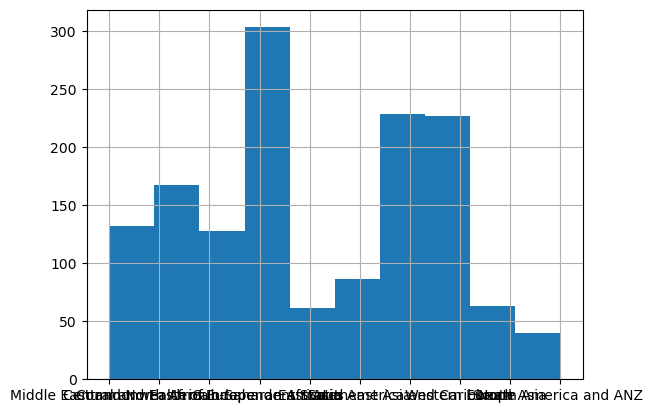

In [50]:
classifier.nodes[0].target.hist()

In [51]:
x_sample = x_train.head(10)
y_sample = y_train.head(10)

y_sample.value_counts()

Central and Eastern Europe            2
Commonwealth of Independent States    2
Southeast Asia                        2
Middle East and North Africa          1
Sub-Saharan Africa                    1
East Asia                             1
Latin America and Caribbean           1
Name: region, dtype: int64

In [52]:
node_options = DecisionTree.NodeOptions()
node_options.max_height = 10
node_options.strategy = 'median'

classifier = DecisionTree.Classifier(max_height=10)
classifier.fit(x_sample, y_sample, node_options)

if is_development:
    classifier.print_tree()

In [53]:
target = classifier.nodes[4].target
strategy = GiniImpuritySplitStrategy()
#strategy.gini_impurity_index(target.value_counts())

#len(classifier.nodes)
classifier.nodes[0].split_info

,feature_name,threshold,gini_impurity_index
0,life_ladder,5.707431,0.72
1,social_support,0.843348,0.68
2,free_to_choose,0.807056,0.76


In [54]:
node = classifier.nodes[0]
temp_df = pd.DataFrame()

temp_df[node.features.columns] = node.features.copy()
temp_df[node.target.name] = node.target.copy()

temp_filt = temp_df[node.feature_name] <= node.threshold
temp_df.loc[temp_filt]

,life_ladder,social_support,free_to_choose,region
1113,5.167187,0.829381,0.607031,Middle East and North Africa
2195,2.693523,0.759162,0.631908,Sub-Saharan Africa
1566,5.965058,0.778192,0.905275,Southeast Asia
773,3.569762,0.564320,0.398295,Latin America and Caribbean
1352,4.434237,0.762995,0.899064,Southeast Asia
